### Importing Dependencies and Importing Data

In [1]:
### Importing Dependencies
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
### Reading the Sample Data
hh_master_details = pd.read_excel('./data/HouseHoldmasterdetail.xlsx', sheet_name='Sheet1')
hh_indv_details = pd.read_excel('./data/HouseholIndividualDetails.xlsx', sheet_name='Sheet1')
viewer_day1_details = pd.read_excel('./data/Viewership data day1.xlsx', sheet_name='Sheet1')
viewer_day2_details = pd.read_excel('./data/Viewership data day2.xlsx', sheet_name='Sheet1')
viewer_day3_details = pd.read_excel('./data/Viewership data day3.xlsx', sheet_name='Sheet1')

In [3]:
### Combining all the viewer day wise data and sorting by Date 
viewer_details = pd.concat([viewer_day1_details, viewer_day2_details, viewer_day3_details])
viewer_details['Date'] = pd.to_datetime(viewer_details['Date'])
viewer_details.sort_values(['Date'], inplace=True)
viewer_details.reset_index(drop=True, inplace=True)

In [4]:
### Combine the master, individual and viewer data as combine data
hh_details = pd.merge(hh_indv_details, hh_master_details, on='HH ID', how='left')
combine_data = pd.merge(viewer_details, hh_details, on = ['HH ID', 'INDIVIDUAL_ID'], how='left')

In [5]:
### Defining Categorical & Numerical Variables
cat_variables = ['HH ID', 'INDIVIDUAL_ID', 'Channels viewed', 'Age_in_years', 'Sex', 'Education', 'Cities', 'AreaID_InsideCity']
num_variables = list(set(combine_data.columns) - set(cat_variables) - set(['Date']))

In [6]:
### Converting the list of numerical variables to categorical 
for x in cat_variables:
    combine_data[x] = combine_data[x].astype(str)

________________________________________________________________________________________________________________________________________________________

### Channel Performance Metric - Daily Level

In [7]:
### Getting the Channel performance
channel_perf_daily = pd.DataFrame(combine_data[['Date', 'Channels viewed', 'Viewership Duration in minutes']].groupby(['Date', 'Channels viewed'])['Viewership Duration in minutes'].sum()).reset_index()
channel_perf_daily = channel_perf_daily.sort_values(['Date', 'Viewership Duration in minutes']).reset_index(drop=True)
channel_perf_daily_pivot = channel_perf_daily.pivot_table(index='Date', columns='Channels viewed', values='Viewership Duration in minutes')

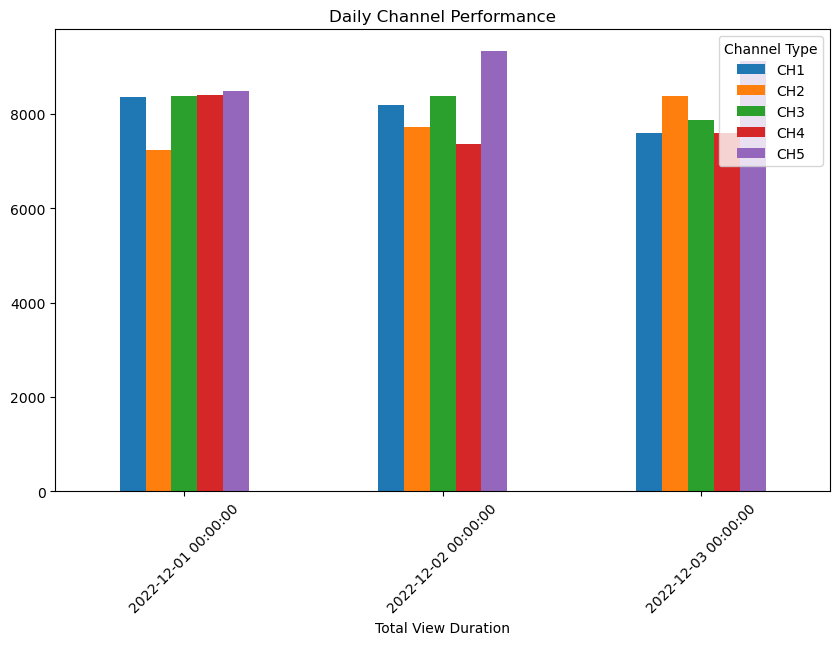

In [8]:
### Plotting Channel Performance
channel_perf_daily_pivot.plot(kind='bar', stacked=False, figsize=(10,6))
plt.xlabel('Date')
plt.xlabel('Total View Duration')
plt.title('Daily Channel Performance')
plt.legend(title='Channel Type')
plt.xticks(rotation=45);

________________________________________________________________________________________________________________________________________________________

## ML Modelling

In [9]:
### Label Encoding the categorical variables
le = LabelEncoder()
for col in cat_variables:
    combine_data[col] = le.fit_transform(combine_data[col])

In [10]:
### Considering 1st & 2nd Day data as train data and 3rd day data as test 
train_data = combine_data[combine_data['Date']< '2022-12-03']
train_data.drop(columns=['Date'], inplace=True)
train_data.reset_index(drop=True, inplace=True)

test_data = combine_data[combine_data['Date']>= '2022-12-03']
test_data.drop(columns=['Date'], inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [11]:
### Dividing into Dependent & Independent variables
X_train = train_data.drop(columns=['Viewership Duration in minutes'])
X_test = test_data.drop(columns=['Viewership Duration in minutes'])
y_train = train_data[['Viewership Duration in minutes']]
y_test = test_data[['Viewership Duration in minutes']]

In [12]:
### Developing the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
### Predicting on test data
y_pred = rf_model.predict(X_test)

In [14]:
### Getting the evaluation metrix
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Square Error: {mse}')
print(f'R-Square Value: {r2}')

Mean Square Error: 1101.499468459646
R-Square Value: -0.2782994696122365


In [15]:
### Feature Importance
feature_imp =  rf_model.feature_importances_
feature_imp = [round(x*100, 2) for x in feature_imp]
feature_name = X_train.columns
important_feature = pd.DataFrame({'Feature':feature_name, 'Importance (%)':feature_imp})
important_feature.sort_values(['Importance (%)'], inplace = True, ascending=False)
print("\n Feature Importance: \n")
print(important_feature)


 Feature Importance: 

             Feature  Importance (%)
2    Channels viewed           23.00
3      STRATA_WEIGHT           19.70
0              HH ID           16.03
4       Age_in_years           15.11
8  AreaID_InsideCity            8.49
1      INDIVIDUAL_ID            6.64
7             Cities            5.30
6          Education            3.10
5                Sex            2.64


_______________________________________________________________________________________________________________________________________________________

### Comments

###### 1. For EDA its difficult to analyze the entire data in a hour with writing the python code to execute it. On the other hand also its been a while I am using python for EDA. From last 5 years I am using Power BI or any other reporting tool for that matter to do the EDA and build reports which is much easy and we don't need to write code for this.

###### 2. Performance Metrix have plot and for ML model its a very basic model with no grid search for tune and also have just used RF model directly where we can explore the basic other model like SVM or DF or other complex model may be before finalizing the model.

###### 3. Also, may be we can create the buckets of the age, combine some area as single area etc and also create some new features may be.

###### 4. Also the R2 is negative which simply means that we will require some more features which is actually meaningful to predict the duration, might remove the unwanted variables, RF model fit is poor and we must check other models, data might be insufficient etc. There can be many other reason also along with this.